### Lesson1 - compressed code

In [ ]:
# broad import
from fastai.vision import *
from fastai.metrics import error_rate

In [35]:
# narrow import
import os
import numpy as np

from fastai.metrics import error_rate

from fastai.vision.transform import get_transforms
from fastai.vision.learner import cnn_learner
from fastai.vision import models
from fastai.train import ClassificationInterpretation

from fastai.vision.data import (ImageDataBunch
                                ,imagenet_stats
                                ,get_image_files
                               )

from fastai.datasets import (URLs
                             ,untar_data
                            )


In [61]:
import fastai
fastai.__version__

In [2]:
path = untar_data(URLs.PETS)
path_anno = path/'annotations'
path_img = path/'images'

fnames = get_image_files(path_img)

np.random.seed(2)

pat = r'/([^/]+)_\d+.jpg$'

In [5]:
bs = 64  #16

data = ImageDataBunch.from_name_re(
                        path=path_img, 
                        fnames=fnames, 
                        pat=pat, 
                        ds_tfms=get_transforms(), 
                        size=224, 
                        bs=bs, 
                        num_workers=0,   #hack
                      )

_ = data.normalize(imagenet_stats)

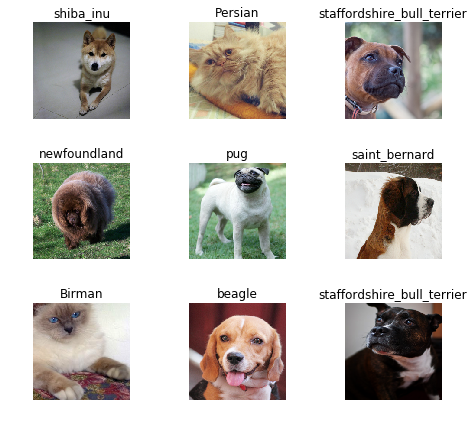

In [6]:
data.show_batch(rows=3, figsize=(7,6))

In [15]:
my_resnet34 = models.resnet34

In [13]:
learn = cnn_learner(data=data, 
                    base_arch=my_resnet34,   
                    pretrained=True,
                    metrics=error_rate,
                   )

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/.torch/models/resnet34-333f7ec4.pth
87306240it [00:02, 36559131.61it/s]


In [14]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.403070,0.337920,0.102842,01:56
1,0.551134,0.268715,0.087280,01:57
2,0.322514,0.226077,0.073072,01:54
3,0.255993,0.216597,0.069012,01:54


In [20]:
learn.save('stage-1')
#how to .load()
# from fastai.basic_train import Learner

### Interpret Model - plots

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

('Ragdoll', 'Birman', 11)
('beagle', 'basset_hound', 6)
('american_bulldog', 'boxer', 4)
('english_cocker_spaniel', 'english_setter', 4)


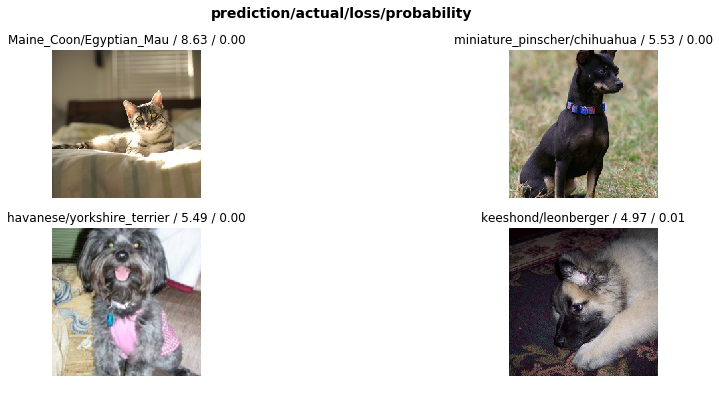

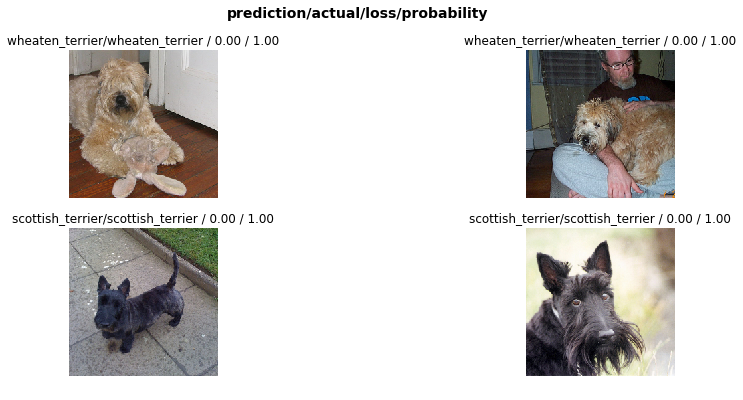

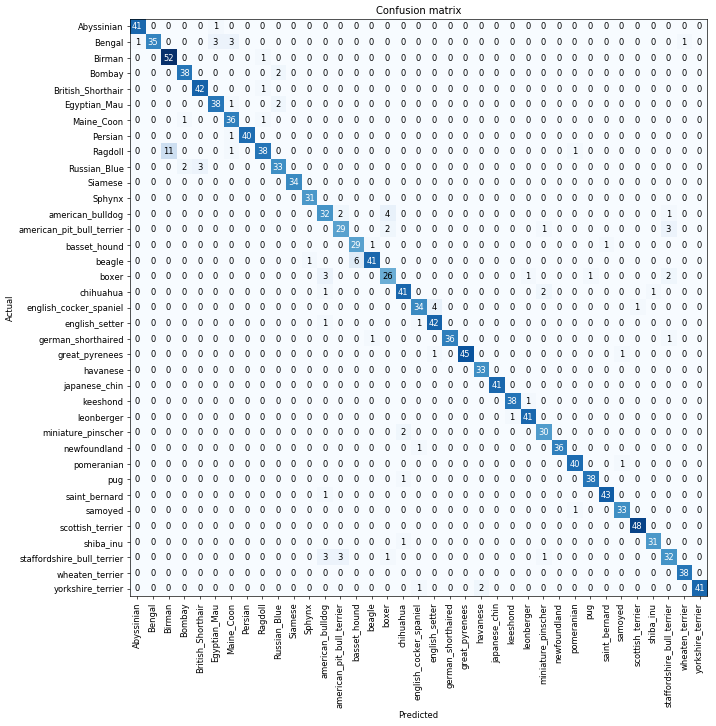

In [33]:
interp.plot_top_losses(4, figsize=(15,6), heatmap=False, largest=True)
interp.plot_top_losses(4, figsize=(15,6), heatmap=False, largest=False)

interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

print(*interp.most_confused(min_val=4), sep='\n')

### Model State - Duplicate / apply more Training / alter

In [43]:
# where are saved models:
os.listdir('/tmp/.fastai/data/oxford-iiit-pet/images/models/')

['stage-1.pth']

In [44]:
#clone learner, is there a way to copy()?

learn.freeze()
# learn.unfreeze()

learn_extra = cnn_learner(
                    data=data, 
                    base_arch=my_resnet34,   
                    pretrained=True,
                    metrics=error_rate,
                   )

In [46]:
#train for an extra time
_ = learn_extra.load('stage-1')

In [47]:
interp_extra_0 = ClassificationInterpretation.from_learner(learn_extra)

In [ ]:
# Get these datapoints
# [ ] num train records, num validation records
# [ ] any holdout test set in dataset?
# [ ] some accuracy metric, for both slices of data e.g. from train() printout

In [60]:
learn_extra.fit_one_cycle(cyc_len=3, 
                          max_lr=slice(1e-6,1e-4), 
                         )

epoch,train_loss,valid_loss,error_rate,time
0,0.213714,0.208885,0.067659,01:55
1,0.209364,0.206500,0.066306,01:54
2,0.204056,0.205692,0.064276,01:53


### Build more Complex Model - resnet50

In [ ]:
data3 = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)